In [191]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models.boost import RentPricePredictor
from src.models.neural_network import NeuralNetworkRegressor, train_nn, evaluate_nn
from src.models import tf_idf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.linear_model import Lasso


import warnings
warnings.filterwarnings('ignore')

In [192]:
plt.rc('font', family='Serif', size=12)
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## ML WORKFLOW

- Prepare Data
    - Retrieve Pricing and Other Information 
        - One Hot Encoding
        - Standard Scaler 
    - Retrieve Unit Amenities 
        - TF-IDF
        - Dimension Reduction
    - Merge
- Model Selection with K folds 
- XG boost hyper paramter tuning
- Comparison to No Text DataFrame


## Pre-Processing

In [193]:


def retrieve_dataset(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')
    # amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    # tf_idf_df = tf_idf.get_tf(amenities_df)
    df = db_manager.retrieve_units(city, state_abbr)
    df['Neighborhood'].replace('', 'Unknown', inplace=True)
    df = df.apply(pd.to_numeric, errors='ignore')
    # return df[df[['RentPrice', 'Latitude', 'Longitude']].notna().all(axis=1)]
    return df.dropna()

def retrieve_amenities(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')
    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    return tf_idf_df



In [194]:
CITY = 'Chicago'
STATE = 'IL'

In [195]:
df = retrieve_dataset(CITY, STATE)
df.describe()

3


,RentPrice,Beds,Baths,SquareFootage,Latitude,Longitude,NumUnits
count,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000
mean,2743.706683,1.166621,1.310311,788.422136,41.897213,-87.645524,96.720845
std,1528.270482,0.963528,0.584888,373.290264,0.050935,0.038097,154.972429
min,495.000000,0.000000,0.000000,1.000000,41.630430,-87.954420,0.000000
25%,1885.000000,0.000000,1.000000,570.000000,41.876380,-87.655140,21.000000
50%,2492.000000,1.000000,1.000000,720.000000,41.889690,-87.640370,43.000000
75%,3174.000000,2.000000,2.000000,935.000000,41.910680,-87.625910,93.000000
max,45000.000000,6.000000,9.000000,9324.000000,42.035910,-87.529380,742.000000


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18359 entries, 2 to 21075
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UnitId         18359 non-null  object 
 1   RentPrice      18359 non-null  float64
 2   Beds           18359 non-null  int64  
 3   Baths          18359 non-null  float64
 4   SquareFootage  18359 non-null  float64
 5   ModelName      18359 non-null  object 
 6   Latitude       18359 non-null  float64
 7   Longitude      18359 non-null  float64
 8   NumUnits       18359 non-null  int64  
 9   Neighborhood   18359 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


In [197]:
print(df.head())

    UnitId  RentPrice  Beds  Baths  SquareFootage      ModelName  Latitude  \
2  5gxgkrm     2307.0     0    1.0          793.0             C3  41.88610   
3  1reqwr7     1795.0     1    1.0          735.0          1bs11  41.80368   
4  94reqc4     2315.0     0    1.0          540.0            E4a  41.89703   
6  7se32qz     4001.0     2    2.0         1055.0             C4  41.89703   
7  kb7pkp9     1879.0     0    1.0          468.0  Studio 1 Bath  41.89680   

   Longitude  NumUnits  Neighborhood  
2  -87.63432        53  Chicago Loop  
3  -87.58492       132       Kenwood  
4  -87.63454        67   River North  
6  -87.63454        67   River North  
7  -87.64119        10   River North  


In [198]:
print(df['Beds'].unique())

[0 1 2 3 4 5 6]


In [199]:
print(df['Baths'].unique())

[1.  2.  9.  3.5 0.  1.5 3.  2.5 4.5 5.  4.  6.5]


In [200]:
print(df['NumUnits'].unique())

[ 53 132  67  10   9  14   6   1  19  28  22   4   8  38  35 742  56  29
   2   3  36  58  46  27  54 225  18 156 126  40  48  37  15  12   7   5
  43  39  11  21  16  20  25  52  33  23  13  24  26  62  34  45 108 142
  30  32  44  99  31  50  60  17  75  92  66  57 159  41  51  65 120  68
 138 245  85  80  88  64  93  82 302 223 137 145  42  81  47  83  71  59
  72  86  49   0 213 122 320]


In [201]:
upper_cutoff = df['RentPrice'].quantile(0.995) 
df = df[df['RentPrice'] <= upper_cutoff]

In [202]:


# def transform_data(df):
#     categorical_columns = ['Beds', 'Baths']
#     numeric_columns = ['SquareFootage']

#     # Identify columns to leave unchanged
#     untransformed_columns = [col for col in df.columns if col not in categorical_columns + numeric_columns]


#     for col in categorical_columns:
#         if col in df.columns:
#             df[col] = df[col].astype(str)


#     df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)


#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numeric_columns),
#             ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_columns)
#         ],
#         remainder='passthrough'  # Keep untransformed columns
#     )


#     transformed_array = preprocessor.fit_transform(df)
#     cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
#     transformed_feature_names = numeric_columns + list(cat_feature_names) + untransformed_columns
#     transformed_df = pd.DataFrame(transformed_array, columns=transformed_feature_names, index=df.index)

#     transformed_df['RentPrice'] = pd.to_numeric(df["RentPrice"], errors="coerce") 
#     transformed_df['RentPrice'] = np.log(transformed_df['RentPrice'] + 1e-6)

#     return transformed_df


def transform_data(df):
    numeric_columns = ['SquareFootage', 'RentPrice']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
   
    df['RentPrice'] = np.log(df['RentPrice'] + 1e-6)
    df['SquareFootage'] = np.log(df['SquareFootage'] + 1e-6)
    df['total_rooms'] = df['Beds'] + df['Baths']

    df.drop(columns=['Beds', 'Baths'], inplace=True)

    return df


In [203]:
main = transform_data(df)

In [204]:

def feature_engineering(df):
    # Neighborhood imputation
    neighborhood_means = df.groupby('Neighborhood')['RentPrice'].mean()
    # neighborhood_means = df.groupby('Neighborhood')['RentPrice'].median()
    df['neighborhood_mean_price'] = df['Neighborhood'].map(neighborhood_means)
    # df.drop('Neighborhood', inplace=True)

    if df[['Latitude', 'Longitude']].dtypes.nunique() > 1:
        print("Warning: Mismatched data types in Latitude/Longitude")

    df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype(float)
    coords = np.radians(df[['Latitude', 'Longitude']].values)
    tree = BallTree(coords, metric='haversine')
    df['density'] = tree.query_radius(coords, r=1e-3, count_only=True)

    df.drop(columns=['Latitude', 'Longitude'], inplace=True)
 
    return df

In [205]:
main = feature_engineering(main)

In [206]:
main.head()

,UnitId,RentPrice,SquareFootage,ModelName,NumUnits,Neighborhood,total_rooms,neighborhood_mean_price,density
2,5gxgkrm,7.743703,6.675823,C3,53,Chicago Loop,1.0,7.869202,13215
3,1reqwr7,7.492760,6.599871,1bs11,132,Kenwood,2.0,7.536242,1543
4,94reqc4,7.747165,6.291569,E4a,67,River North,1.0,8.039309,13335
6,7se32qz,8.294300,6.961296,C4,67,River North,4.0,8.039309,13335
7,kb7pkp9,7.538495,6.148468,Studio 1 Bath,10,River North,1.0,8.039309,13467


<Axes: >

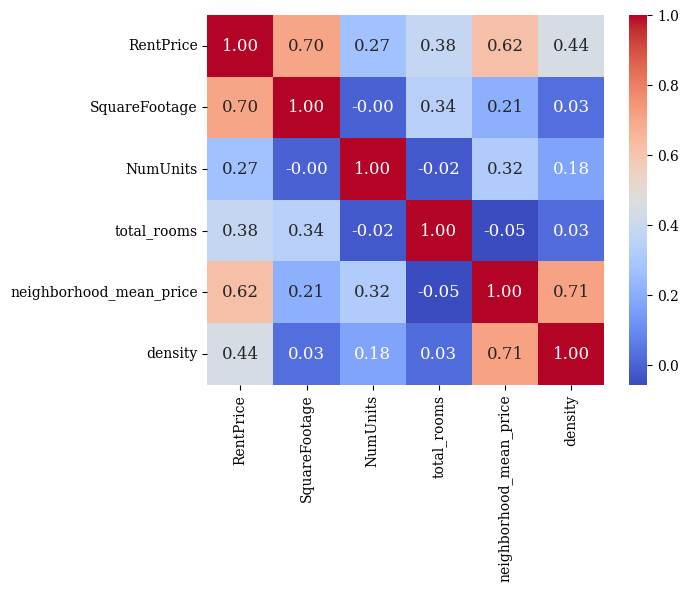

In [207]:
import seaborn as sns 
corr_matrix = main.drop(columns=['Neighborhood', 'UnitId', 'ModelName']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

## Dimension Reduction of Amenity TF-IDF


find number of components using a scree graph

In [208]:
tf = retrieve_amenities(CITY, STATE)

In [209]:
tf

,UnitId,10,10th,11,11th,12,14,15k,16,1b,...,wood,work,x34,x8pktw9_rs4,xfinity,yard,yoga,your,youtu,zipcar
0,000syd0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,003rss3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,003xq20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0048zb0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,004xyl1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21071,zzvfy9y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21072,zzw3hwx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21073,zzwb79x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21074,zzznryz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
unit_id = tf['UnitId']
tf = tf.drop(columns=['UnitId'])

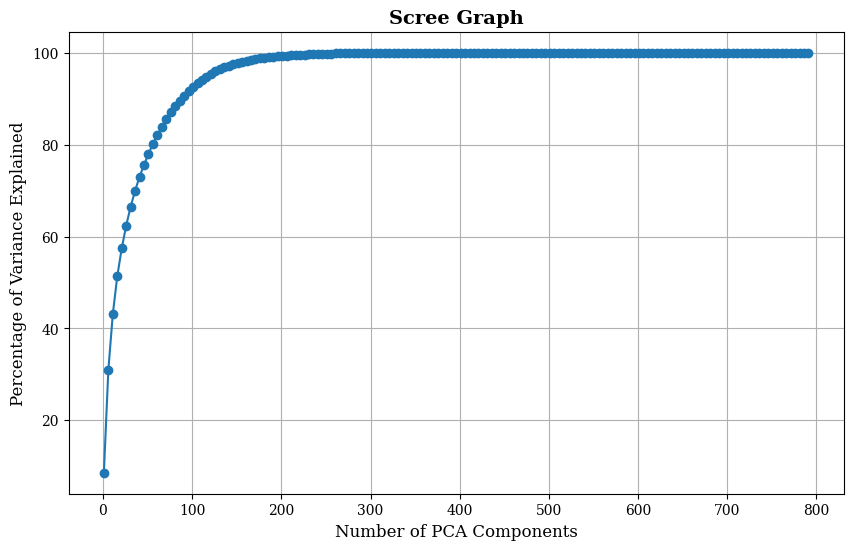

In [211]:

# Initialize PCA and fit the model to the scaled data
pca = PCA()
pca.fit(tf)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
components_tested = np.arange(1, len(cumulative_explained_variance) + 1, 5)
selected_variance = cumulative_explained_variance[components_tested - 1]

plt.figure(figsize=(10, 6))
plt.plot(components_tested, selected_variance * 100, marker='o')
plt.title("Scree Graph")
plt.xlabel("Number of PCA Components")
plt.ylabel("Percentage of Variance Explained")
plt.grid(True)
plt.show()


In [212]:
pca = PCA(n_components=.85, svd_solver = "full")
tf = pd.DataFrame(pca.fit_transform(tf))

In [213]:
tf['UnitId'] = unit_id

### Merge

In [214]:
merged_df = pd.merge(main, tf, on='UnitId')

In [215]:

def prepare_data(df):

    X = df.drop(columns=['UnitId', 'RentPrice', 'ModelName', 'Neighborhood']).fillna(0.0).to_numpy()
    y = df['RentPrice']

    return X, np.array(y)


In [216]:
X,y = prepare_data(merged_df)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Model Selection using K folds validation 

In [218]:


kf = KFold(n_splits=5)

xgb_mse_scores = []
nn_mse_scores = []
lasso_mse_scores = []

# Store true values for all test sets
all_test_targets = []

counter = 1
# Loop over each split in the repeated K-Fold
for train_idx, val_idx in kf.split(X_train):
    print(f"Fold {counter}")
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train and evaluate XGBoost
    xgb_model  = RentPricePredictor()
    xgb_model.train_model(X_train_fold, y_train_fold)
    xgb_mse = xgb_model.evaluate_model(X_val_fold, y_val_fold)
    xgb_mse_scores.append(xgb_mse)

    # Train and evaluate Neural Network
    nn_model = train_nn(X_train_fold, y_train_fold)
    nn_mse, nn_pred = evaluate_nn(nn_model, X_test, y_test)
    nn_mse_scores.append(nn_mse)

    lasso_model = Lasso(alpha=0.01)  # Alpha = L1 regularization strength
    lasso_model.fit(X_train_fold, y_train_fold)
    lasso_pred = lasso_model.predict(X_val_fold)
    lasso_mse = mean_squared_error(y_val_fold, lasso_pred)
    lasso_mse_scores.append(lasso_mse)


    counter += 1





Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [219]:
average_xgboost_mse = np.mean(xgb_mse_scores) 
average_nn_mse = np.mean(nn_mse_scores)
average_lasso_mse = np.mean(lasso_mse_scores)

print(f"Average XGBoost MSE: {average_xgboost_mse}")
print(f"Average Neural Network MSE: {average_nn_mse}")
print(f"Average Lasso MLE: {average_lasso_mse}")


Average XGBoost MSE: 0.01419156586557272
Average Neural Network MSE: 0.15954091995954514
Average Lasso MLE: 0.040683216764777826


## XG Boost hyper parameter tuning

In [220]:
boost = RentPricePredictor()
best_model, best_params, best_score = boost.tune_xgboost_hyperparameters(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation MSE: 0.0080


In [221]:
best_model.fit(X_train, y_train) 
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(mse)

0.008003000253551202


In [222]:
feature_importance = xgb_model.model.feature_importances_
features = merged_df.drop(columns=['UnitId', 'RentPrice', 'ModelName', 'Neighborhood']).columns

# # Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df[:15])

,Feature,Importance
0,SquareFootage,0.204787
3,neighborhood_mean_price,0.183165
7,2,0.086014
4,density,0.054262
1,NumUnits,0.048392
2,total_rooms,0.037456
6,1,0.024172
64,59,0.021871
55,50,0.015351
72,67,0.013948


Plotting

In [234]:
def plot_mse_distribution(ax, mse_scores):
    ax.hist(mse_scores)
    ax.set_title("Mean Squared Error Across Folds")
    ax.set_xlabel("Distribution of Folds")
    ax.set_ylabel("MSE")

# Function for Actual vs Predicted Scatter Plot
def plot_actual_vs_predicted(ax, y_test, y_pred):
    y_test_original = np.exp(y_test)  # Convert back to original scale
    y_pred_original = np.exp(y_pred)  # Convert back to original scale

    ax.scatter(y_test_original, y_pred_original, alpha=0.5, color='grey')
    ax.plot([min(y_test_original), max(y_test_original)], 
            [min(y_test_original), max(y_test_original)], 
            color='red', linestyle='--')
    
    ax.set_xlabel("Actual Rent Price")
    ax.set_ylabel("Predicted Rent Price")
    ax.set_title("Actual vs Predicted Rent Prices")

# Function for Residuals Analysis
def plot_residuals(y_test, y_pred, model_name):
    """Plots residuals distribution and residuals vs actual values."""
    
    # Convert back to original scale (if log transformation was applied)
    y_test_original = np.exp(y_test)
    y_pred_original = np.exp(y_pred)
    
    # Calculate residuals
    residuals = y_test_original - y_pred_original

    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram of residuals
    axes[0].hist(residuals, bins='auto',color='black', alpha=0.7)
    axes[0].set_title(f"Residual Distribution: {model_name}")
    axes[0].set_xlabel("Residuals")
    # axes[0].set_xscale('log')
    axes[0].set_ylabel("Frequency")
    axes[0].set_xlim((-2000, 2000))

    # Residuals plot against y_test_original
    axes[1].scatter(y_test_original, residuals, alpha=0.6, color='grey')
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_title(f"Residuals vs. True Values: {model_name}")
    axes[1].set_xlabel("Actual Rent Price")
    axes[1].set_ylabel("Residuals")
    # axes[1].set_xscale('log')
    plt.tight_layout()
    plt.show()



Results

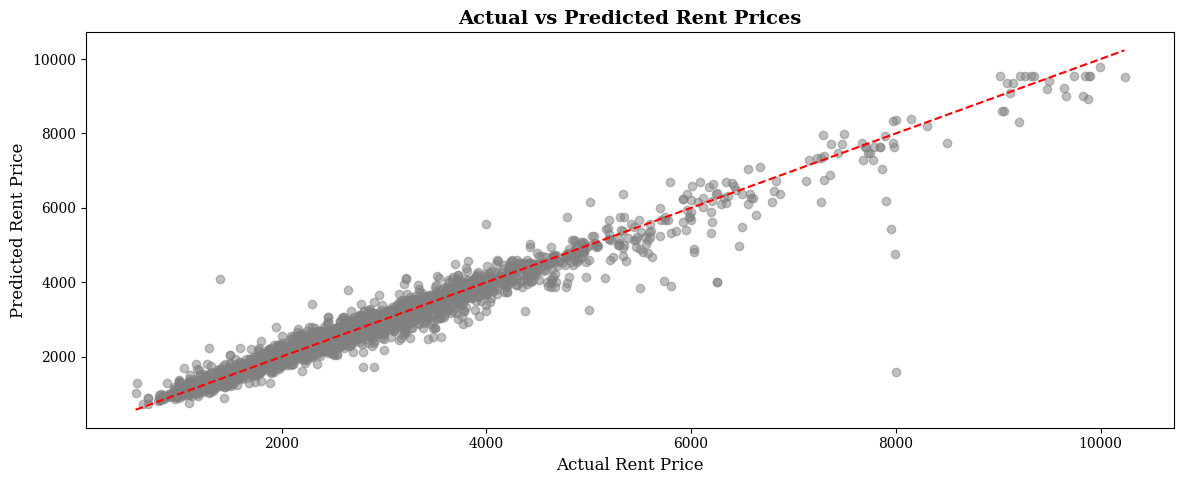

In [235]:

fig, ax = plt.subplots(figsize=(12, 5))  

# plot_mse_distribution(ax[0], xgboost_mse_scores)
plot_actual_vs_predicted(ax, y_test, preds)

plt.tight_layout()
plt.savefig('pred')
plt.show()


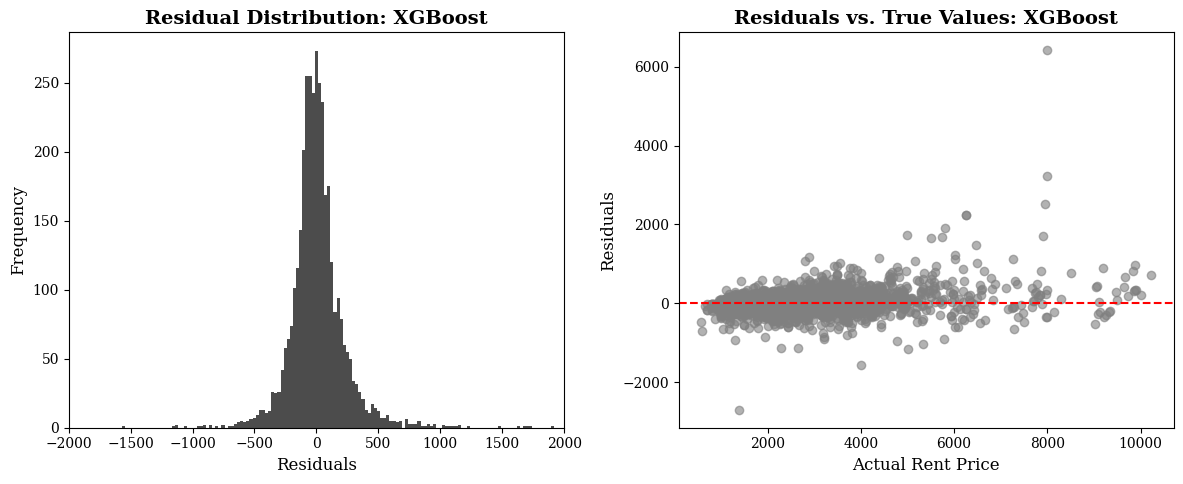

In [236]:
plot_residuals(y_test, preds, 'XGBoost')

### Comparing to model without text data

In [226]:

# Perform train-test split while keeping indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [227]:

X_no_text, y_no_text = prepare_data(main)

train_indices = np.arange(len(X_train))  
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Use integer-based indexing
X_train_no_text = X_no_text[train_indices] 
X_test_no_text = X_no_text[test_indices]   

# Ensure `y_no_text` remains a Pandas Series for indexing
y_train_no_text = y_no_text[train_indices]  
y_test_no_text = y_no_text[test_indices]    


In [228]:
boost = RentPricePredictor()
best_model1, best_params, best_score = boost.tune_xgboost_hyperparameters(X_train_no_text, y_train_no_text)

boost = RentPricePredictor()
best_model2, best_params, best_score = boost.tune_xgboost_hyperparameters(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation MSE: 0.0097
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation MSE: 0.0080


In [229]:

best_model1.fit(X_train_no_text,y_train_no_text)
best_model2.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=99, ...)

In [230]:


no_text_preds = best_model1.predict(X_test_no_text)
no_text_mse = mean_squared_error(no_text_preds, y_test_no_text)

preds = best_model.predict(X_test)
mse = mean_squared_error(preds, y_test)

percentage_improvement = ((no_text_mse - mse) / no_text_mse) * 100

print(f"No Text: {no_text_mse}")
print(f"With TF-IDF: {mse}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

No Text: 0.017772726070385655
With TF-IDF: 0.008003000253551202
Percentage Improvement: 54.97%
